# In this file we fit our model with the real data.

In [302]:
from datetime import datetime
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import norm, chi2

from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox  

from Garch import GARCH

#### Define helper functions 

In [303]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')  
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")

    if result[1] <= 0.05:
        print(" The series is stationary (reject H0)")
    else:
        print(" The series is non-stationary (fail to reject H0)")

In [304]:
def generate_ar_data(ar_coef, T):
    res = [0]
    for t in range(1,T):
        res.append(ar_coef * res[-1] + random.gauss(0, 1))

    return res

In [305]:
def likelihood_ratio_test(ll_null: float, ll_alternative: float, df: int):
    if df <= 0:
        raise ValueError("Degrees of freedom must be positive.")
    if ll_alternative < ll_null:
        raise ValueError("ll_null should be smaller than ll_alternative.")
    
    # Compute test statistic
    lr_stat = 2 * (ll_alternative - ll_null)
    
    # Compute p-value
    p_value = 1 - chi2.cdf(lr_stat, df)
    
    return p_value

## 1. Load Data
1. S&P500 data
2. Sentiment data (consisting of mean Positive, Negative and Neutral sentiment per day)
3. VIX (for comparison purpose)

In [306]:
start = '2019-10-01'
end = '2024-09-27'

In [307]:
# Load S&P data
prices_df = pd.read_csv('../data/spy_prices.csv')
prices_df.index = pd.to_datetime(prices_df['Date'], format='%Y-%m-%d %H:%M:%S%z', utc=True).dt.date
#Load market sentiment v1 and v2
market_v1 = pd.read_csv('../data/market_gpt_summarised_v1.csv')
market_v2 = pd.read_csv('../data/market_gpt_summarised_v2.csv')


## Dropping Irrelevant columns

In [308]:
market_v1 = market_v1.drop(columns = ['Unnamed: 0'])
market_v2 = market_v2.drop(columns = ['Unnamed: 0'])


## Aggregating by day

In [309]:
agg_func = {
            'pos_sentiment': 'mean',
            'neg_sentiment': 'mean',
            'neutral_sentiment': 'mean',
            'pos_sentiment_w_preamb': 'mean',
            'neg_sentiment_w_preamb': 'mean',
            'neutral_sentiment_w_preamb': 'mean'}
column_rename = {
            'pos_sentiment': 'mean_pos_sentiment',
            'neg_sentiment': 'mean_neg_sentiment',
            'neutral_sentiment': 'mean_neutral_sentiment',
            'pos_sentiment_w_preamb': 'mean_pos_preamble_sentiment',
            'neg_sentiment_w_preamb': 'mean_neg_preamble_sentiment',
            'neutral_sentiment_w_preamb': 'mean_neutral_preamble_sentiment'}

market_v1 = market_v1.groupby(by='adjusted_date').agg(agg_func).rename(columns=column_rename).reset_index()
market_v2 = market_v2.groupby(by='adjusted_date').agg(agg_func).rename(columns=column_rename).reset_index()


In [310]:
market_v1.index = pd.DatetimeIndex(market_v1['adjusted_date'])
market_v2.index = pd.DatetimeIndex(market_v2['adjusted_date'])



In [311]:
# Merge all into one dataframe
#FOR V1
#vix.index = pd.DatetimeIndex(vix.index.tz_localize(None))
data_with_sentiment_v1 = prices_df.join(market_v1, how='inner')#.join(vix[['VIX Close']], how='left')
data_with_sentiment_v1 = data_with_sentiment_v1.drop(columns=['Date'])

data_with_sentiment_v1['neg_sentiment_lag1'] = data_with_sentiment_v1['mean_neg_sentiment'].shift(1)
data_with_sentiment_v1['neg_sentiment_diff'] = data_with_sentiment_v1['mean_neg_sentiment'] - data_with_sentiment_v1['neg_sentiment_lag1']
#data_with_sentiment = data_with_sentiment.dropna()
data_with_sentiment_v1 = data_with_sentiment_v1[1:]
#data_with_sentiment = data_with_sentiment.join(t_rates_df)
# Fill missing i/r data. Missing data is sparse, but might have to investigate.
#data_with_sentiment = data_with_sentiment.ffill()
data_with_sentiment_v1.head()




,Open,High,Low,Close,Volume,returns,log_returns,adjusted_date,mean_pos_sentiment,mean_neg_sentiment,mean_neutral_sentiment,mean_pos_preamble_sentiment,mean_neg_preamble_sentiment,mean_neutral_preamble_sentiment,neg_sentiment_lag1,neg_sentiment_diff
2019-10-01,275.616000,276.282500,271.228221,271.450378,88242400,-0.011895,-0.011966,2019-10-01,0.288219,0.601452,0.110329,0.338735,0.573120,0.088145,0.955273,-0.353822
2019-10-02,269.839692,269.848958,265.340835,266.655304,122539500,-0.017665,-0.017823,2019-10-02,0.243740,0.720978,0.035283,0.244466,0.706273,0.049261,0.601452,0.119526
2019-10-03,266.423921,268.867766,263.656106,268.839996,85278800,0.008193,0.008160,2019-10-03,0.265927,0.643434,0.090639,0.261413,0.594602,0.143986,0.720978,-0.077544
2019-10-04,269.506467,272.737129,269.450899,272.477936,65091200,0.013532,0.013441,2019-10-04,0.228237,0.699255,0.072508,0.270606,0.659174,0.070220,0.643434,0.055821
2019-10-07,271.663341,273.320341,271.015344,271.302307,59610500,-0.004315,-0.004324,2019-10-07,0.014666,0.933866,0.051468,0.021445,0.912205,0.066350,0.699255,0.234611


In [312]:
# Merge all into one dataframe
#FOR V2
#vix.index = pd.DatetimeIndex(vix.index.tz_localize(None))
data_with_sentiment_v2 = prices_df.join(market_v2, how='inner')#.join(vix[['VIX Close']], how='left')
data_with_sentiment_v2 = data_with_sentiment_v2.drop(columns=['Date'])

data_with_sentiment_v2['neg_sentiment_lag1'] = data_with_sentiment_v2['mean_neg_sentiment'].shift(1)
data_with_sentiment_v2['neg_sentiment_diff'] = data_with_sentiment_v2['mean_neg_sentiment'] - data_with_sentiment_v2['neg_sentiment_lag1']
#data_with_sentiment = data_with_sentiment.dropna()
data_with_sentiment_v2 = data_with_sentiment_v2[1:]
#data_with_sentiment = data_with_sentiment.join(t_rates_df)
# Fill missing i/r data. Missing data is sparse, but might have to investigate.
#data_with_sentiment = data_with_sentiment.ffill()
data_with_sentiment_v2.head()

,Open,High,Low,Close,Volume,returns,log_returns,adjusted_date,mean_pos_sentiment,mean_neg_sentiment,mean_neutral_sentiment,mean_pos_preamble_sentiment,mean_neg_preamble_sentiment,mean_neutral_preamble_sentiment,neg_sentiment_lag1,neg_sentiment_diff
2019-10-01,275.616000,276.282500,271.228221,271.450378,88242400,-0.011895,-0.011966,2019-10-01,0.361718,0.597809,0.040472,0.355887,0.578455,0.065658,0.968639,-0.370830
2019-10-02,269.839692,269.848958,265.340835,266.655304,122539500,-0.017665,-0.017823,2019-10-02,0.351372,0.610212,0.038416,0.343986,0.603940,0.052074,0.597809,0.012403
2019-10-03,266.423921,268.867766,263.656106,268.839996,85278800,0.008193,0.008160,2019-10-03,0.400572,0.555986,0.043443,0.383394,0.531560,0.085045,0.610212,-0.054226
2019-10-04,269.506467,272.737129,269.450899,272.477936,65091200,0.013532,0.013441,2019-10-04,0.383925,0.582152,0.033924,0.365818,0.572592,0.061590,0.555986,0.026166
2019-10-07,271.663341,273.320341,271.015344,271.302307,59610500,-0.004315,-0.004324,2019-10-07,0.008483,0.963325,0.028192,0.009336,0.955142,0.035522,0.582152,0.381173


## GARCH X Model Function

In [313]:
def train_model(log_returns,exo_sentiment, log_returns_scale_factor, exo_scale_factor, use_constraints, method = 'L-BFGS-B', z = 1):
    garch_with_sentiment = GARCH(p=1, q=1, z=z, verbose=True)
    garch_with_sentiment.train(log_returns_scale_factor*log_returns, x = exo_scale_factor * exo_sentiment,use_constraints= use_constraints, method = method)
    return garch_with_sentiment.summary()



    

In [314]:
data_with_sentiment_v1.index = data_with_sentiment_v1['adjusted_date']
data_with_sentiment_v2.index = data_with_sentiment_v2['adjusted_date']


In [315]:
exo_sentiment = ['mean_pos_preamble_sentiment', 'mean_neg_preamble_sentiment','mean_neutral_preamble_sentiment']
neg_sentiment = ['mean_neg_preamble_sentiment']
log_returns_v1 = data_with_sentiment_v1['log_returns']
log_returns_v2 = data_with_sentiment_v2['log_returns']


## V2 model

In [316]:
train_model(log_returns_v2, data_with_sentiment_v2[exo_sentiment],1000,10,False,'SLSQP')

Optimising...
Optimising finished in 2.777s
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 5.637971379021877
       x: [-1.004e+00 -1.851e+00 -2.018e-01 -2.822e+00 -2.786e+00
           -8.291e-01]
     nit: 28
     jac: [ 9.912e-05 -7.868e-05 -4.373e-04 -1.323e-05 -1.544e-05
            1.690e-04]
    nfev: 198
    njev: 28
{'omega': 0.366554453963864, 'alpha': 0.15700882547924094, 'beta': 0.8172923849753698, 'gamma': array([[0.05946562, 0.06167678, 0.4364613 ]])}


,coef,std err,t,P>|t|
omega,0.366554,9.419953,0.038913,4.844832e-01
alpha,0.157009,0.025813,6.082570,7.891699e-10
beta,0.817292,0.027416,29.811093,1.375794e-147
gamma[0],0.059466,0.260856,0.227964,4.098563e-01
gamma[1],0.061677,0.145994,0.422460,3.363818e-01
gamma[2],0.436461,1.156470,0.377408,3.529678e-01


### PCA

In [317]:
# ! pip install scikit-learn
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca_exo_sentiment = pca.fit_transform(data_with_sentiment_v2[exo_sentiment])
# PCA non-differenced
train_model(log_returns_v2, pca_exo_sentiment,1000,100,False,'SLSQP')

Optimising...
Optimising finished in 1.217s
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 5.6386381827824605
       x: [-8.371e-01 -1.883e+00 -1.854e-01 -5.418e+00]
     nit: 17
     jac: [-6.612e-04  4.023e-05  4.528e-04  9.316e-05]
    nfev: 90
    njev: 17
{'omega': 0.43296588553727106, 'alpha': 0.15206987888919216, 'beta': 0.8307940007894506, 'gamma': array([[0.00443408]])}


,coef,std err,t,P>|t|
omega,0.432966,1.197800,0.361468,3.589061e-01
alpha,0.152070,0.022924,6.633633,2.451490e-11
beta,0.830794,0.022505,36.916494,1.803630e-201
gamma[0],0.004434,0.002038,2.175977,1.487378e-02


## GARCH Baseline

In [318]:
train_model(log_returns_v2, data_with_sentiment_v2['mean_neg_preamble_sentiment'],1000,100,False,'SLSQP',0)

Optimising...
Optimising finished in 1.513s
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 5.639004431881456
       x: [ 1.280e+00 -1.855e+00 -1.956e-01]
     nit: 27
     jac: [-7.927e-06  1.359e-04  5.264e-04]
    nfev: 119
    njev: 27
{'omega': 3.5980967210664776, 'alpha': 0.1564491030305711, 'beta': 0.8223398823930537, 'gamma': array([], shape=(0, 1), dtype=float64)}


,coef,std err,t,P>|t|
omega,3.598097,1.001276,3.593510,1.695940e-04
alpha,0.156449,0.025228,6.201524,3.814814e-10
beta,0.822340,0.025610,32.110048,5.618121e-165


# PACF and ACF Plots for PCA S&P

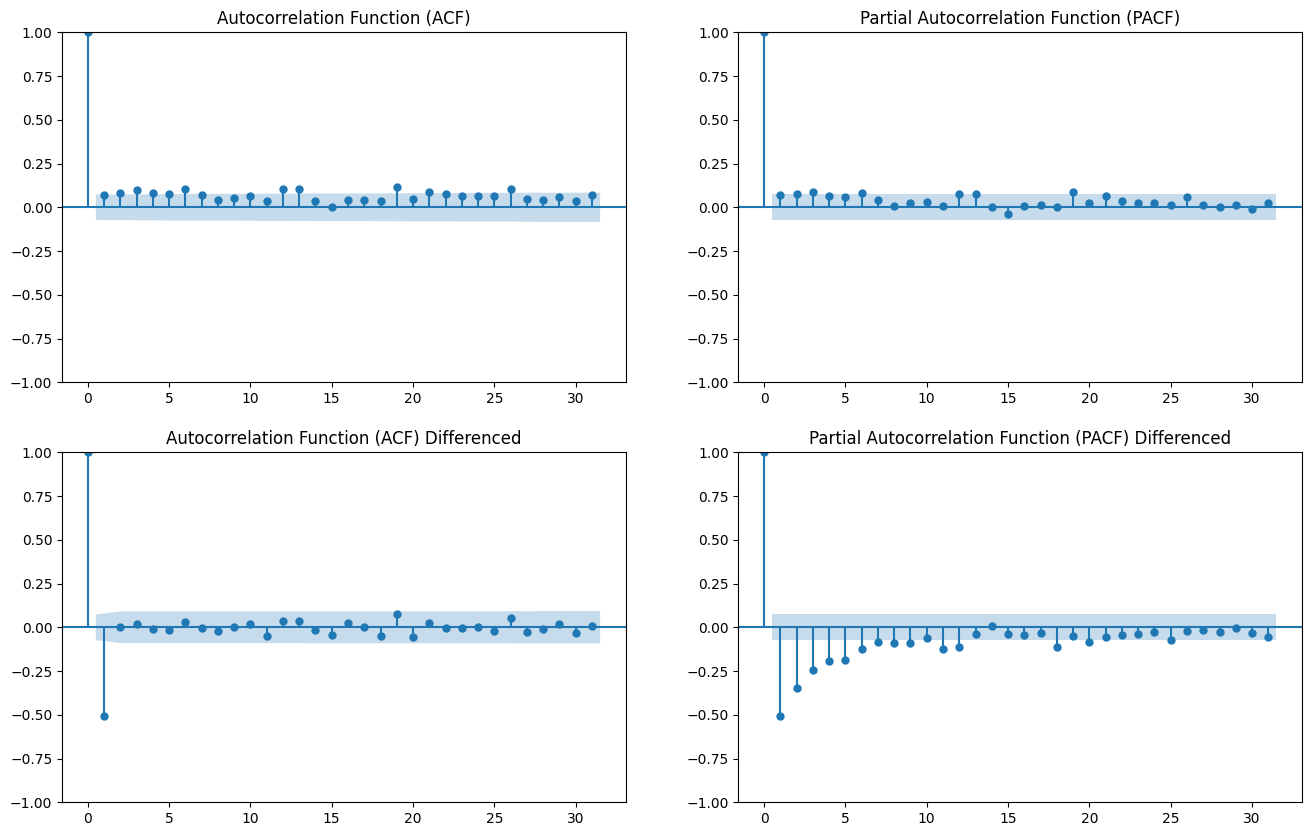

In [319]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set figure size
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ACF plot
plot_acf((pca_exo_sentiment),alpha = 0.01, ax=axes[0][0])
axes[0][0].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf((pca_exo_sentiment),alpha = 0.01, ax=axes[0][1])
axes[0][1].set_title("Partial Autocorrelation Function (PACF)")

# ACF plot
plot_acf(np.diff(pca_exo_sentiment,axis = 0),alpha = 0.01, ax=axes[1][0])
axes[1][0].set_title("Autocorrelation Function (ACF) Differenced")

# PACF plot
plot_pacf(np.diff(pca_exo_sentiment,axis = 0),alpha = 0.01, ax=axes[1][1])
axes[1][1].set_title("Partial Autocorrelation Function (PACF) Differenced")


# Show plots
plt.show()


In [320]:
print("ADF Test for X:")
adf_test(pca_exo_sentiment)

ADF Test for X:
ADF Statistic: -4.912682151197674
p-value: 3.294533984159011e-05
Critical Values:
   1%: -3.4357748759345768
   5%: -2.8639355566269677
   10%: -2.5680454348767596
 The series is stationary (reject H0)


## Graph Plot for S&P Time series

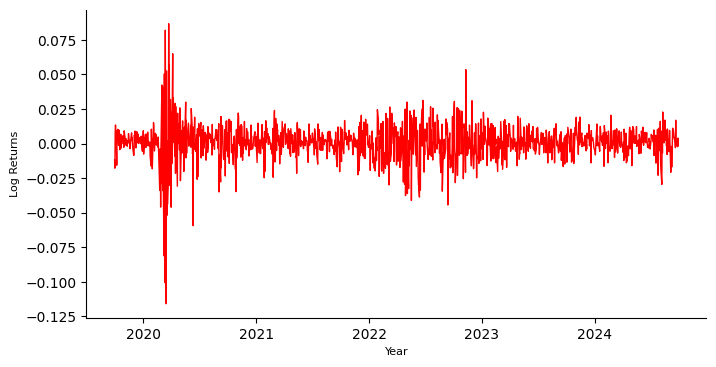

In [321]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed

# Plot the log returns
ax.plot(prices_df['log_returns'], color="red", linewidth=1, label="Log Returns")

# Manually set the background to a subtle grey (like seaborn-darkgrid)
#ax.set_facecolor("#f5f5f5")  

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add axis labels
ax.set_xlabel("Year", fontsize=8)
ax.set_ylabel("Log Returns", fontsize=8)

# Add a title
#ax.set_title("Time Series of Log Returns", fontsize=10)

# Customize tick parameters for better readability
ax.tick_params(axis="both", which="major", labelsize=10)

# Add gridlines (light gray for a subtle effect)
#ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7, color="gray")

# Add a legend (optional)
#ax.legend(frameon=False, fontsize=10)

# Show the plot
plt.show()
